In [ ]:
!pip install scikit-learn optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.3 MB/s eta 0:00:00


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alicer5/currencydataset")

print("Path to dataset files:", path)

100%|██████████| 338M/338M [00:01<00:00, 204MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alicer5/currencydataset/versions/1


In [ ]:
path = f'{path}/CurrencyDataset'

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# re-size all the images to this
DL_IMAGE_SIZE = [256, 256]
BATCH_SIZE = 32
EPOCHS = 100

train_path = f"{path}/train"
valid_path = f"{path}/test"

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from skimage.io import imread
from skimage.transform import resize
import optuna

# Parameters
IMAGE_SIZE = (256, 256)  # You can change this
data_dir = train_path  # Replace with your path

X = []
y = []

# Walk through dataset
for data_dir in [train_path,valid_path]:
    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if not os.path.isdir(label_path):
            continue
        for img_file in os.listdir(label_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(label_path, img_file)
                img = imread(img_path, as_gray=True)  # Convert to grayscale
                img_resized = resize(img, IMAGE_SIZE, anti_aliasing=True)
                X.append(img_resized.flatten())
                y.append(f"{label}")

X = np.array(X)
y = np.array(y)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---------------------------
# ✅ Optuna Optimization
# ---------------------------
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e1)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])

    model = SVC(C=C, gamma=gamma, kernel=kernel)

    # Cross-validation
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print best parameters
print("\n🔧Currency Dataset -SVM - Best Hyperparameters:")
print(study.best_params)

# Train final model with best parameters
best_model = SVC(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-07-30 17:59:34,303] A new study created in memory with name: no-name-0859fe67-f091-45b9-8b94-b7238c7251df
[I 2025-07-30 18:00:21,827] Trial 0 finished with value: 0.5036036036036036 and parameters: {'C': 0.0012967415305179622, 'gamma': 0.13923831864349767, 'kernel': 'rbf'}. Best is trial 0 with value: 0.5036036036036036.
[I 2025-07-30 18:01:07,012] Trial 1 finished with value: 0.5036036036036036 and parameters: {'C': 0.00355714839168356, 'gamma': 0.02522510325101744, 'kernel': 'rbf'}. Best is trial 0 with value: 0.5036036036036036.
[I 2025-07-30 18:01:21,219] Trial 2 finished with value: 0.5124839124839125 and parameters: {'C': 721.4219118202383, 'gamma': 0.4040683360144167, 'kernel': 'poly'}. Best is trial 2 with value: 0.5124839124839125.
[I 2025-07-30 18:01:35,532] Trial 3 finished with value: 0.5124839124839125 and parameters: {'C': 0.010336960689134833, 'gamma': 0.012440141954154766, 'kernel': 'poly'}. Best is trial 2 with value: 0.5124839124839125.
[I 2025-07-30 18:01:49,


🔧Currency Dataset -SVM - Best Hyperparameters:
{'C': 48.222744762585464, 'gamma': 0.3328599187308878, 'kernel': 'linear'}


SVC(C=48.222744762585464, gamma=0.3328599187308878, kernel='linear')

In [ ]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

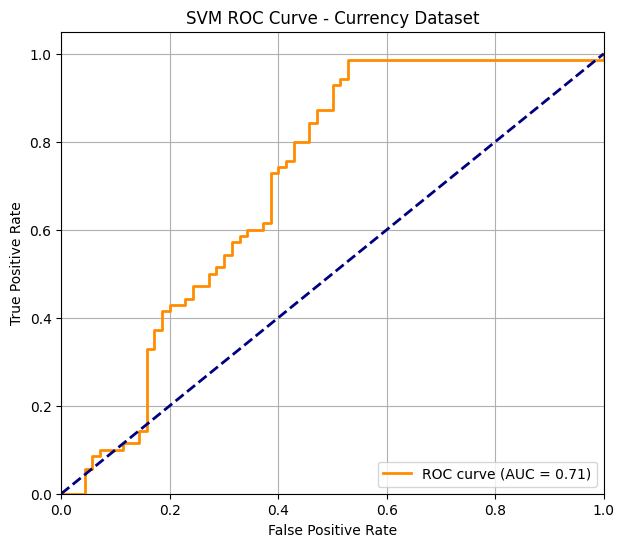

In [ ]:
# Plot SVM Accuracy and ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# --- Accuracy Bar Plot (already shown above as svm_acc) ---
# print("\n✅ SVM Classification Accuracy:", svm_acc)

# --- ROC Curve ---
# For binary classification, get probability estimates
if len(le.classes_) == 2:
    # SVC with probability=True is needed for predict_proba
    best_model_prob = SVC(**study.best_params, probability=True)
    best_model_prob.fit(X_train, y_train)
    y_score = best_model_prob.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('SVM ROC Curve - Currency Dataset')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print("ROC curve is only available for binary classification.")


📊 SVM Currency Dataset - Classification Report:
              precision    recall  f1-score   support

        Fake       0.64      0.61      0.63        70
        Real       0.63      0.66      0.64        70

    accuracy                           0.64       140
   macro avg       0.64      0.64      0.64       140
weighted avg       0.64      0.64      0.64       140


✅ SVM Classification Accuracy: 0.6357142857142857


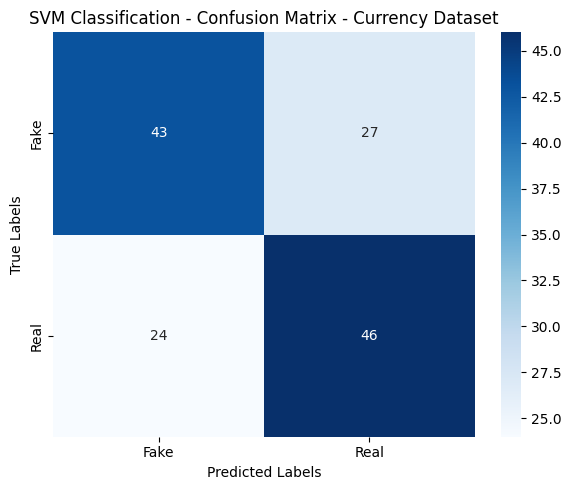

In [ ]:

# Predict and evaluate
y_pred = best_model.predict(X_test)

print("\n📊 SVM Currency Dataset - Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
svm_acc = accuracy_score(y_test, y_pred)
print("\n✅ SVM Classification Accuracy:", svm_acc)
# print("\n📉 Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names = le.classes_

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('SVM Classification - Confusion Matrix - Currency Dataset')
plt.tight_layout()
plt.show()


In [ ]:
import joblib

# Save model
joblib.dump(best_model, 'currency_svm_real_fake_model.joblib')

# Save scaler (important to apply the same preprocessing during inference)
joblib.dump(scaler, 'currency_scaler.joblib')

# Save label encoder
joblib.dump(le, 'currency_label_encoder.joblib')

['currency_label_encoder.joblib']

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications import efficientnet_v2, resnet_v2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# re-size all the images to this
DL_IMAGE_SIZE = [256, 256]
BATCH_SIZE = 32
EPOCHS = 100

train_path = f"{path}/train"
valid_path = f"{path}/test"

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
# Data generators
eff_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_v2.preprocess_input,
        shear_range=0.2,
        zoom_range = 0.2,
        featurewise_center= True
)

res_datagen = ImageDataGenerator(
    preprocessing_function=resnet_v2.preprocess_input,
        shear_range=0.2,
        zoom_range = 0.2,
        featurewise_center= True
)


cnn_datagen = ImageDataGenerator(
    rescale = 1./255,
        shear_range=0.2,
        zoom_range = 0.2,
        featurewise_center= True
)

Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.

EfficientNet Model - PreprocessInput


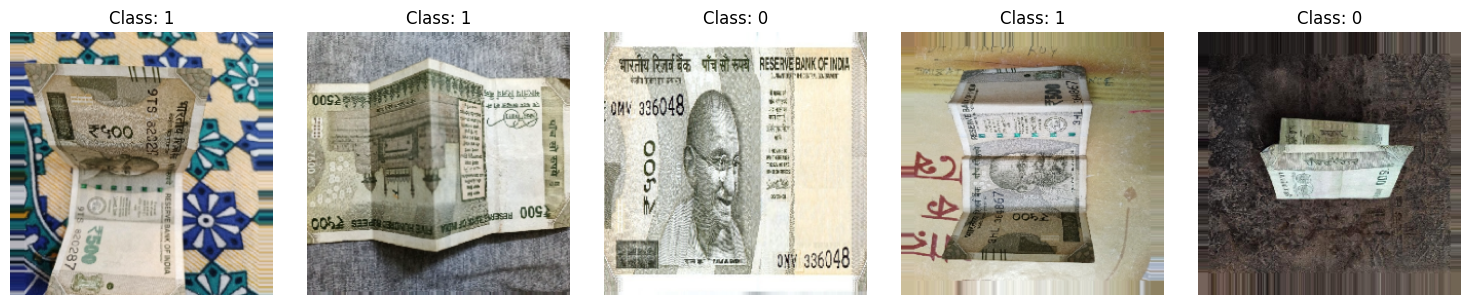


Resnet Model - PreprocessInput


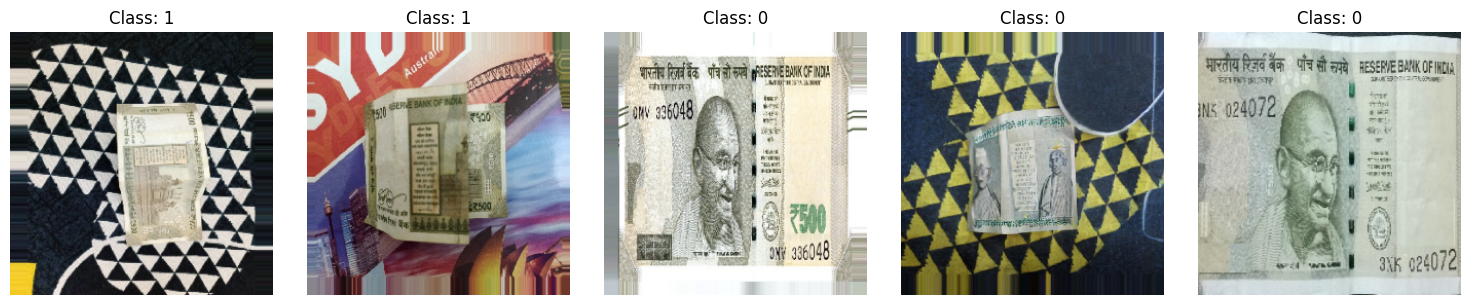


CNN Model - PreprocessInput


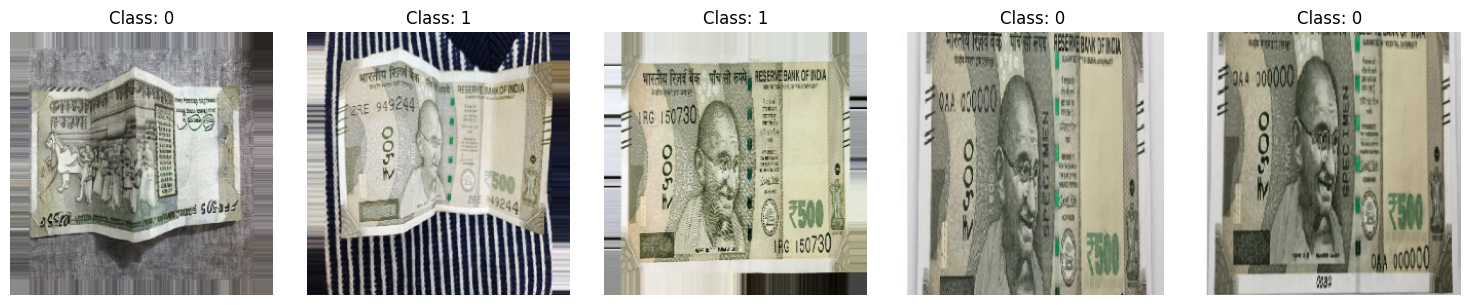

In [ ]:
eff_generator = eff_datagen.flow_from_directory(
    train_path,            # 📁 Should contain class subfolders (e.g., Real/, Fake/)
    target_size=DL_IMAGE_SIZE,      # Match model input size
    batch_size=BATCH_SIZE,
    classes=['Fake', 'Real'],
    class_mode='categorical',
    shuffle=True                # So you always get the same images
)

res_generator = eff_datagen.flow_from_directory(
    train_path,            # 📁 Should contain class subfolders (e.g., Real/, Fake/)
    target_size=DL_IMAGE_SIZE,      # Match model input size
    batch_size=BATCH_SIZE,
    classes=['Fake', 'Real'],
    class_mode='categorical',
    shuffle=True                # So you always get the same images
)
cnn_generator = eff_datagen.flow_from_directory(
    train_path,            # 📁 Should contain class subfolders (e.g., Real/, Fake/)
    target_size=DL_IMAGE_SIZE,      # Match model input size
    batch_size=BATCH_SIZE,
    classes=['Fake', 'Real'],
    class_mode='categorical',
    shuffle=True                # So you always get the same images
)


def view_process(images, labels, title):
    # Randomly select 5 from the batch
    indices = random.sample(range(len(images)), 5)
    print(f"\n{title}")
    # Plot them
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img = images[idx]

        # Normalize back for visualization
        img = img - np.min(img)
        img = img / np.max(img)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {np.argmax(labels[idx])}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Get one batch
images, labels = next(eff_generator)
view_process(images, labels, "EfficientNet Model - PreprocessInput")
images, labels = next(res_generator)
view_process(images, labels, "Resnet Model - PreprocessInput")
images, labels = next(cnn_generator)
view_process(images, labels, "CNN Model - PreprocessInput")

In [ ]:
def dataset_split(class_mode, datagenerator):
    train_gen = datagenerator.flow_from_directory(
        train_path,
        target_size=DL_IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        classes=['Fake', 'Real'],  # Only look for these subfolders in each currency
        shuffle=True
    )

    valid_gen = datagenerator.flow_from_directory(
        valid_path,
        target_size=DL_IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=class_mode,
        classes=['Fake', 'Real'],  # Only look for these subfolders in each currency
        shuffle=True
    )

    return train_gen, valid_gen

In [ ]:

eff_train_gen, eff_valid_gen = dataset_split('categorical', eff_datagen)

# Load EfficientNetV2B0 base model
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(DL_IMAGE_SIZE[0], DL_IMAGE_SIZE[0], 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(eff_train_gen.num_classes, activation='softmax')(x)

output = Dense(eff_valid_gen.num_classes, activation='softmax')(x)

eff_model = Model(inputs=base_model.input, outputs=output)

# Optionally, freeze base model for transfer learning
# base_model.trainable = False

# Compile model
eff_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)

# Model summary
# eff_model.summary()

# Train model
hist_efficient = eff_model.fit(
    eff_train_gen,
    epochs=EPOCHS,
    validation_data=eff_valid_gen
)

# Save model
eff_model.save("currency_efficientnetv2_model.keras")

Found 500 images belonging to 2 classes.
Found 196 images belonging to 2 classes.
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step - AUC: 0.5993 - Precision: 0.5566 - Recall: 0.5566 - accuracy: 0.5566 - loss: 1.0566 - val_AUC: 0.7898 - val_Precision: 0.6939 - val_Recall: 0.6939 - val_accuracy: 0.6939 - val_loss: 0.6263
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 968ms/step - AUC: 0.6800 - Precision: 0.6252 - Recall: 0.6252 - accuracy: 0.6252 - loss: 0.8942 - val_AUC: 0.8186 - val_Precision: 0.7347 - val_Recall: 0.7347 - val_accuracy: 0.7347 - val_loss: 0.5931
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 984ms/step - AUC: 0.7851 - Precision: 0.7230 - Recall: 0.7230 - accuracy: 0.7230 - loss: 0.7256 - val_AUC: 0.8886 - val_Precision: 0.8061 - val_Recall: 0.8061 - val_accuracy: 0.8061 - val_loss: 0.5479
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 984ms/step - AUC: 0.8338 - Precision: 0.7483 - Recall: 0.7483 - accuracy: 0.7483 - loss: 0.605

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load your trained classification model
# Load model
class_labels = ['Fake', 'Real']
# Path to directory containing test images
image_directory = f"/content"  # Set your image directory here

# Get image files
image_files = [f for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

image_files.sort()

# Show 2 images per row
num_images = len(image_files)
num_cols = 2
num_rows = (num_images + 1) // 2  # Ensure even if odd number of images

plt.figure(figsize=(12, 6 * num_rows))

for idx, image_file in enumerate(image_files):
    image_path = os.path.join(image_directory, image_file)

    # Load image as PIL
    img = image.load_img(image_path, target_size=DL_IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Apply preprocessing using the datagen
    # Use eff_datagen as it was used for training the eff_model
    img_array_processed = eff_datagen.standardize(img_array)

    # Predict
    predictions = eff_model.predict(img_array_processed)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_label = class_labels[predicted_class_index]

    confidence = predictions[0][predicted_class_index]

    # Plot image
    plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(image.load_img(image_path))
    plt.axis('off')
    plt.title(f"{image_file}\n{predicted_class_label}: ({confidence:.2f})", color='green' if predicted_class_label == 'Real' else 'red', fontsize=10)

plt.tight_layout()
plt.show()


<Figure size 1200x0 with 0 Axes>

In [ ]:
cnn_train_gen, cnn_valid_gen = dataset_split('categorical', cnn_datagen)
cnn_model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(DL_IMAGE_SIZE[0], DL_IMAGE_SIZE[0], 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(120, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Use 'sigmoid' for binary classification
])


# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Use 'binary_crossentropy' for binary classification
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

hist_cnn = cnn_model.fit(
    cnn_train_gen,
    epochs=EPOCHS,
    validation_data=cnn_valid_gen
    # callbacks=[early_stop]
)

cnn_model.save("currency_cnn_model.keras")

Found 500 images belonging to 2 classes.
Found 196 images belonging to 2 classes.
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - AUC: 0.4312 - Precision: 0.4543 - Recall: 0.4543 - accuracy: 0.4543 - loss: 14.0693 - val_AUC: 0.6532 - val_Precision: 0.5102 - val_Recall: 0.5102 - val_accuracy: 0.5102 - val_loss: 0.6799
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 980ms/step - AUC: 0.5619 - Precision: 0.5519 - Recall: 0.5519 - accuracy: 0.5519 - loss: 0.7794 - val_AUC: 0.5445 - val_Precision: 0.5561 - val_Recall: 0.5561 - val_accuracy: 0.5561 - val_loss: 0.6924
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 976ms/step - AUC: 0.5478 - Precision: 0.5382 - Recall: 0.5382 - accuracy: 0.5382 - loss: 0.6913 - val_AUC: 0.5324 - val_Precision: 0.5306 - val_Recall: 0.5306 - val_accuracy: 0.5306 - val_loss: 0.6929
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 985ms/step - AUC: 0.6389 - Precision: 0.6140 - Recall: 0.6140 - accuracy: 0.6140 - loss: 0.6768 - val_AUC: 0.5970 - val_Precision: 0.6276 - val_R

In [ ]:
from tensorflow.keras.applications import ResNet50

res_train_gen, res_valid_gen = dataset_split('categorical', res_datagen)
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Use 'sigmoid' for binary classification

# Combine the base model with custom classification layers
res_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
res_model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use 'binary_crossentropy' for binary classification
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

# Train the model
hist_resnet = res_model.fit(res_train_gen, epochs=EPOCHS, validation_data=res_valid_gen)

# Save the trained model
res_model.save("currency_resnet_model.keras")

Found 500 images belonging to 2 classes.
Found 196 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - AUC: 0.5183 - Precision: 0.5253 - Recall: 0.5253 - accuracy: 0.5253 - loss: 0.8034 - val_AUC: 0.6525 - val_Precision: 0.6378 - val_Recall: 0.6378 - val_accuracy: 0.6378 - val_loss: 0.6685
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 985ms/step - AUC: 0.5948 - Precision: 0.5585 - Recall: 0.5585 - accuracy: 0.5585 - loss: 0.6892 - val_AUC: 0.7389 - val_Precision: 0.7041 - val_Recall: 0.7041 - val_accuracy: 0.7041 - val_loss: 0.6573
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 964ms/step - AUC: 0.7360 - Precision: 0.6777 - Recall: 0.6777 - accuracy: 0.6777 - loss: 0.6168 - val_AUC: 0.7363 - val_Precision: 0.6735 - val_Recall: 0.6735 - val_accuracy: 0.6735 - val_loss: 0.6349
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 982ms/step - AUC: 0.7193 - Precision: 0.6886 - Recall: 0.6886 - accuracy: 0.6886 - loss: 0.6260

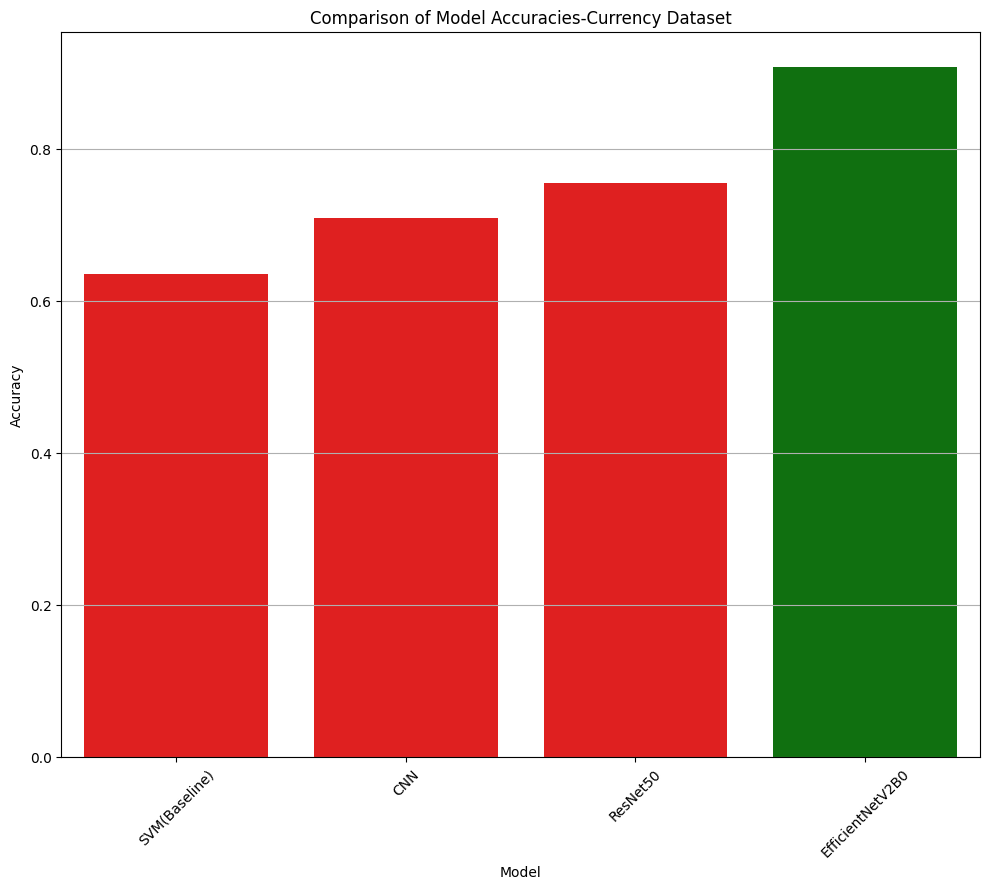

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extract accuracies
cnn_acc = hist_cnn.history['val_accuracy'][-1]
resnet_acc = hist_resnet.history['val_accuracy'][-1]
efficient_acc = hist_efficient.history['val_accuracy'][-1]

# Assuming svm_acc is already defined
data = {
    'Model': ['SVM(Baseline)', 'CNN', 'ResNet50', 'EfficientNetV2B0'],
    'Accuracy': [svm_acc, cnn_acc, resnet_acc, efficient_acc]
}

df = pd.DataFrame(data)

# Identify the highest accuracy
max_acc = df['Accuracy'].max()

# Define colors: red for highest, default (blue) for others
colors = ['green' if acc == max_acc else 'red' for acc in df['Accuracy']]

# Plot
plt.figure(figsize=(10, 9))
sns.barplot(x='Model', y='Accuracy', data=df, palette=colors)

plt.title('Comparison of Model Accuracies-Currency Dataset')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
df

Model  Accuracy
0     SVM(Baseline)  0.635714
1               CNN  0.709184
2          ResNet50  0.755102
3  EfficientNetV2B0  0.908163

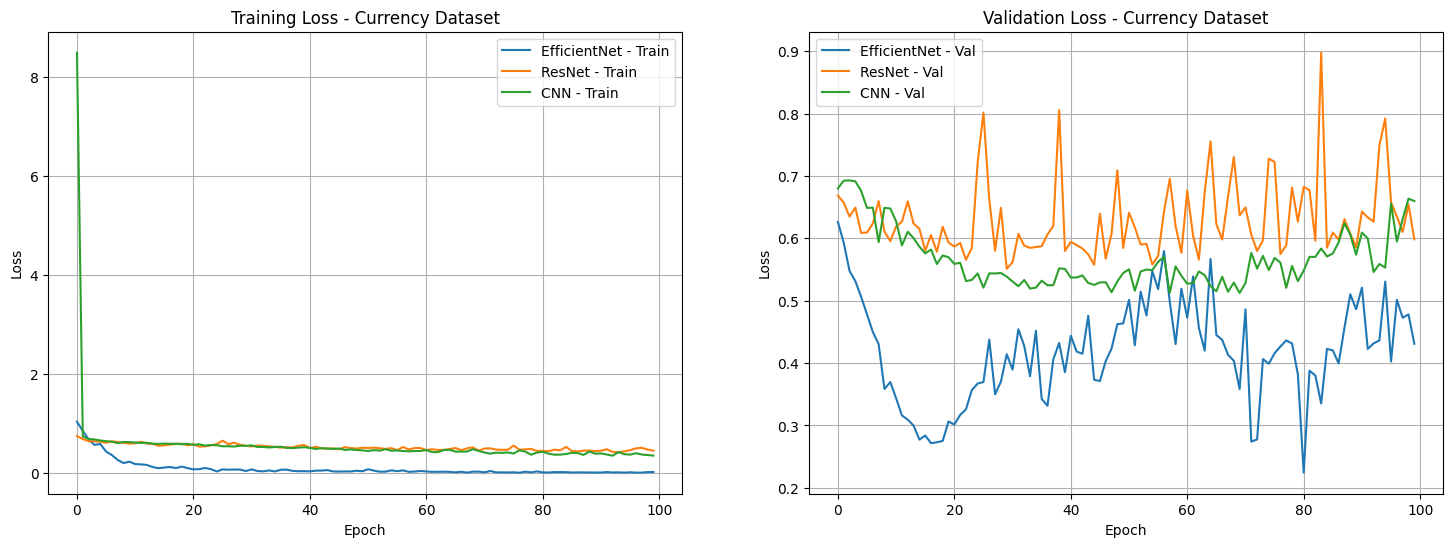

In [ ]:
import matplotlib.pyplot as plt

# Create a wide figure with 2 plots side-by-side
plt.figure(figsize=(18, 6))

# -------------------- Plot 1: Training & Validation Loss --------------------
plt.subplot(1, 2, 1)
plt.plot(hist_efficient.history['loss'], label='EfficientNet - Train')
# plt.plot(hist_efficient.history['val_loss'], label='EfficientNet - Val')

plt.plot(hist_resnet.history['loss'], label='ResNet - Train')
# plt.plot(hist_resnet.history['val_loss'], label='ResNet - Val')

plt.plot(hist_cnn.history['loss'], label='CNN - Train')
# plt.plot(hist_cnn.history['val_loss'], label='CNN - Val')

plt.title('Training Loss - Currency Dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# -------------------- Plot 1: Training & Validation Loss --------------------
plt.subplot(1, 2, 2)
# plt.plot(hist_efficient.history['loss'], label='EfficientNet - Train')
plt.plot(hist_efficient.history['val_loss'], label='EfficientNet - Val')

# plt.plot(hist_resnet.history['loss'], label='ResNet - Train')
plt.plot(hist_resnet.history['val_loss'], label='ResNet - Val')

# plt.plot(hist_cnn.history['loss'], label='CNN - Train')
plt.plot(hist_cnn.history['val_loss'], label='CNN - Val')

plt.title('Validation Loss - Currency Dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)



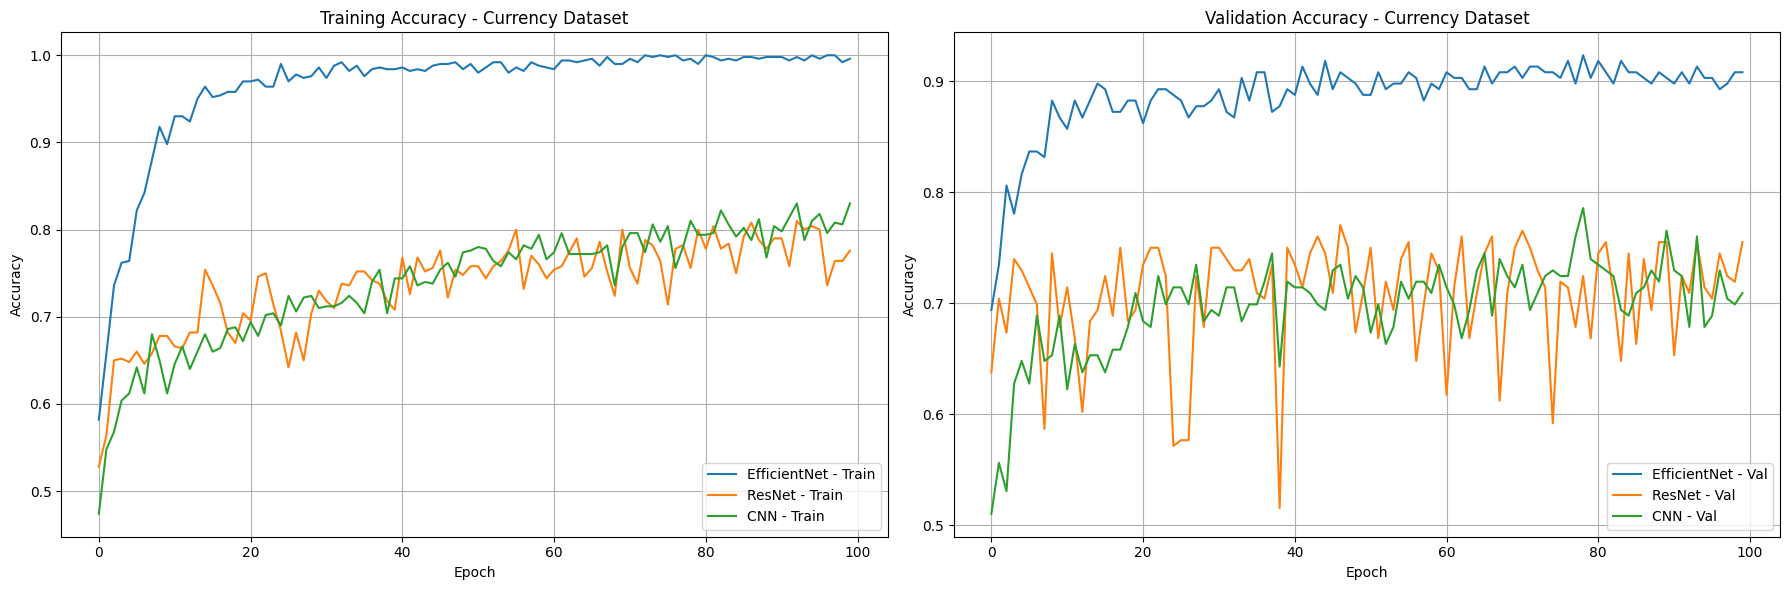

In [ ]:
plt.figure(figsize=(18, 6))
# -------------------- Plot 2: Training & Validation Accuracy --------------------
plt.subplot(1, 2, 2)
# plt.plot(hist_efficient.history['accuracy'], label='EfficientNet - Train')
plt.plot(hist_efficient.history['val_accuracy'], label='EfficientNet - Val')

# plt.plot(hist_resnet.history['accuracy'], label='ResNet - Train')
plt.plot(hist_resnet.history['val_accuracy'], label='ResNet - Val')

# plt.plot(hist_cnn.history['accuracy'], label='CNN - Train')
plt.plot(hist_cnn.history['val_accuracy'], label='CNN - Val')

plt.title('Validation Accuracy - Currency Dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 1)
plt.plot(hist_efficient.history['accuracy'], label='EfficientNet - Train')
# plt.plot(hist_efficient.history['val_accuracy'], label='EfficientNet - Val')

plt.plot(hist_resnet.history['accuracy'], label='ResNet - Train')
# plt.plot(hist_resnet.history['val_accuracy'], label='ResNet - Val')

plt.plot(hist_cnn.history['accuracy'], label='CNN - Train')
# plt.plot(hist_cnn.history['val_accuracy'], label='CNN - Val')

plt.title('Training Accuracy - Currency Dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# -------------------- Show All --------------------
plt.tight_layout()
plt.show()

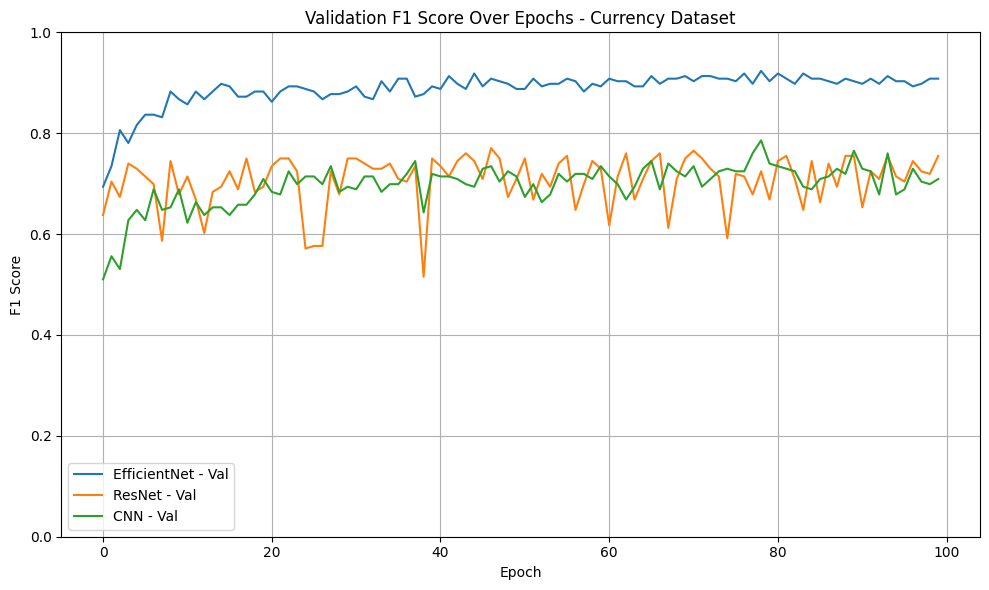

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to compute F1 Score
def compute_f1(precision, recall):
    return [2 * p * r / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

# Compute F1 Scores for each model
f1_resnet = compute_f1(hist_resnet.history['val_Precision'], hist_resnet.history['val_Recall'])
f1_eff = compute_f1(hist_efficient.history['val_Precision'], hist_efficient.history['val_Recall'])
f1_cnn = compute_f1(hist_cnn.history['val_Precision'], hist_cnn.history['val_Recall'])

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(f1_eff, label='EfficientNet - Val')
plt.plot(f1_resnet, label='ResNet - Val')
plt.plot(f1_cnn, label='CNN - Val')

plt.title('Validation F1 Score Over Epochs - Currency Dataset')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import time

# Take one sample from X_test
sample = X_test[:1]

# Measure prediction time
start_time = time.time()
y_score = best_model.predict(sample)
end_time = time.time()

prediction_time = end_time - start_time
print(f"Prediction time for one sample: {prediction_time:.6f} seconds")
print("Predicted label:", y_score[0])

Prediction time for one sample: 0.053655 seconds
Predicted label: 1


In [ ]:
print("Number of samples in SVM X_train:", len(X_train))
print("Number of samples in SVM X_test:", len(X_test))

Number of samples in SVM X_train: 556
Number of samples in SVM X_test: 140


In [ ]:
print("SVM X_train shape:", X_train.shape)
print("SVM X_test shape:", X_test.shape)

SVM X_train shape: (556, 65536)
SVM X_test shape: (140, 65536)


In [ ]:
# Load image as PIL
img = image.load_img(f'{path}/val/IndianCurrency-Fake-1.png', target_size=DL_IMAGE_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Apply preprocessing using the datagen
# Use eff_datagen as it was used for training the eff_model
img_array_processed = cnn_datagen.standardize(img_array)

# Predict
predictions = cnn_model.predict(img_array_processed)
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_labels[predicted_class_index]

confidence = predictions[0][predicted_class_index]
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


array([[0.9177215, 0.0822785]], dtype=float32)

In [ ]:
# Load image as PIL
img = image.load_img(f'{path}/val/IndianCurrency-Fake-1.png', target_size=DL_IMAGE_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Apply preprocessing using the datagen
# Use eff_datagen as it was used for training the eff_model
img_array_processed = res_datagen.standardize(img_array)

# Predict
predictions = res_model.predict(img_array_processed)
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_labels[predicted_class_index]

confidence = predictions[0][predicted_class_index]
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[0.466962  , 0.53303796]], dtype=float32)

In [ ]:


# Compress the output directory
!zip -r /content/CurrencyDatasetMLDL.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.07.29/ (stored 0%)
  adding: content/.config/logs/2025.07.29/13.36.15.785307.log (deflated 57%)
  adding: content/.config/logs/2025.07.29/13.36.36.776594.log (deflated 57%)
  adding: content/.config/logs/2025.07.29/13.36.37.567476.log (deflated 56%)
  adding: content/.config/logs/2025.07.29/13.36.27.119914.log (deflated 58%)
  adding: content/.config/logs/2025.07.29/13.35.49.066514.log (deflated 92%)
  adding: content/.config/logs/2025.07.29/13.36.25.001588.log (deflated 86%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configur

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


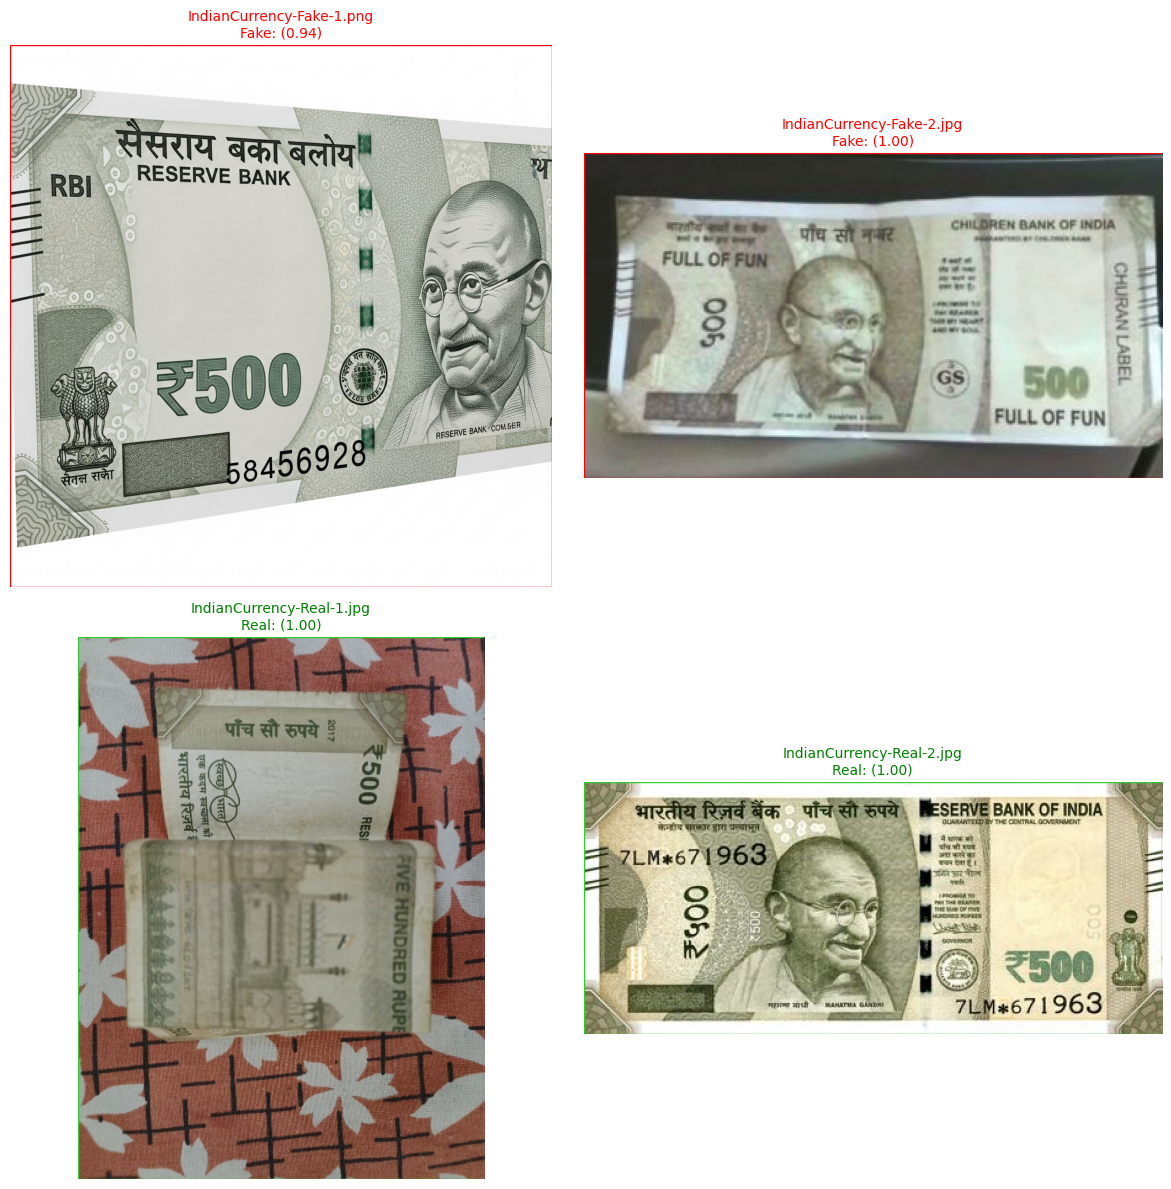

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load your trained classification model
# Load model
class_labels = ['Fake', 'Real']
# Path to directory containing test images
image_directory = f"{path}/val"  # Set your image directory here

# Get image files
image_files = [f for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

image_files.sort()
# Model.load_model('EfficientNetV2B0.h5')  # Load your EfficientNetV2B0 model
eff_model = tf.keras.models.load_model('currency_efficientnetv2_model.keras', custom_objects={'EfficientNetV2B0': EfficientNetV2B0})
# Show 2 images per row
num_images = len(image_files)
num_cols = 2
num_rows = (num_images + 1) // 2  # Ensure even if odd number of images

plt.figure(figsize=(12, 6 * num_rows))
from matplotlib import patches
for idx, image_file in enumerate(image_files):
    image_path = os.path.join(image_directory, image_file)

    # Load image as PIL
    img = image.load_img(image_path, target_size=DL_IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Apply preprocessing using the datagen
    # Use eff_datagen as it was used for training the eff_model
    img_array_processed = eff_datagen.standardize(img_array)

    # Predict
    predictions = eff_model.predict(img_array_processed)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_label = class_labels[predicted_class_index]

    confidence = predictions[0][predicted_class_index]

    # img = image.load_img(image_path)
    # new_size = (img.width // 2, img.height // 2)
    # img = img.resize(new_size)
    # img_np = np.array(img)

    # Plot
    ax = plt.subplot(num_rows, num_cols, idx + 1)
    ax.imshow(image.load_img(image_path))
    ax.axis('off')
    # ax.set_title(f"{image_file}\n{class_name}: {confidence:.2f}", fontsize=10)
    ax.set_title(f"{image_file}\n{predicted_class_label}: ({confidence:.2f})", color='green' if predicted_class_label == 'Real' else 'red', fontsize=10)
    # Draw rectangle border around image
    rect = patches.Rectangle(
        (0, 0), 1, 1,
        transform=ax.transAxes,  # Use axes coordinates (0 to 1)
        linewidth=1,
        edgecolor='limegreen' if predicted_class_label == "Real" else 'red',
        facecolor='none'
    )
    ax.add_patch(rect)


    # # Plot image
    # plt.subplot(num_rows, num_cols, idx + 1)
    # plt.imshow(image.load_img(image_path))
    # plt.axis('off')
    # plt.title(f"{image_file}\n{predicted_class_label}: ({confidence:.2f})", color='green' if predicted_class_label == 'Real' else 'red', fontsize=10)

plt.tight_layout()
plt.show()
